In [2]:
%reset -f

import pandas as pd
import numpy
import time
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
import pandas as pd
import numpy
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import time
import pandas as pd
import os.path
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2 
from sklearn.metrics import mean_squared_log_error
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Image, display
import tensorflow
os.environ['PATH'] += ';C:\\Program Files\\Graphviz\\bin'
import graphviz
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor



from sklearn.model_selection import KFold

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

# !pip install talos
import talos


def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [3]:
environment_variables = dir()

In [4]:
# Input parameters
# Input parameters
TRAINING_FILES = ["../data/original/training_dataset.csv"
, "..\data\preprocessed\difference_preprocessed_training_dataset.csv"
, "..\data\preprocessed\ole_RemoveOutliers_and_preprocessing_pipe_training_dataset.csv"]
EVALUATION_FILES = ["../data/original/evaluation_dataset.csv"
, "..\data\preprocessed\difference_preprocessed_evaluation_dataset.csv"
, "..\data\preprocessed\ole_RemoveOutliers_and_preprocessing_pipe_evaluation_dataset.csv"]

FILE_N = 0
INPUT_TRAINING_FILE = TRAINING_FILES[FILE_N] # "../data/original/training_dataset.csv"
INPUT_EVALUATION_FILE = EVALUATION_FILES[FILE_N] # "../data/original/evaluation_dataset.csv"


# Output parameters
METHOD_NAME = "keras_tensorflow_resnet"
TIMESTAMP = time.strftime("%d_%m_%Y-%H_%M_%S")
OUTPUT_MODEL_FOLDER = f"../data/models/keras_models"
OUTPUT_MODEL = f"../data/models/{METHOD_NAME}_model_{TIMESTAMP}.pkl"
OUTPUT_RESULTS = f"../data/results/{METHOD_NAME}_model_{TIMESTAMP}.txt"
OUTPUT_MODEL_ARCHITECTURE_RESULTS = f"../img/{METHOD_NAME}_model_{TIMESTAMP}.png"

# Hyper parameter alternatives
# Bankrupt companies must have higher weight, because there are fewer samples

# Hyper parameter optimization parameters
HYPER_PARAMETER_OPTIMIZATION_SCORING = "accuracy"
HYPER_PARAMETER_OPTIMIZATION_CV = 5

# Cross validation parameters
CROSS_VALIDATION_CV = 5

# Cost parameters
PUNISHMENT_FOR_FALSE_BANKRUPT_PREDICTION = 100

# Other constants
LABELS = ["Operational", "Bankrupt"]
RANDOM_SEED = 42

# Hyper parameter alternatives
HYPER_PARAMETER_K_FEATURES = list(range(30, 90, 10))
HYPER_PARAMETER_SCORE_FUNC = [chi2, f_classif]
HYPER_PARAMETER_HIDDEN_LAYER_SIZES = [(100,)]
#HYPER_PARAMETER_HIDDEN_LAYER_SIZES = [(100,), (100, 100), (100, 100, 100),
#    (200,), (200, 200), (200, 200, 200), (100, 500)]
HYPER_PARAMETER_ALPHA = list(10.0 ** -numpy.arange(1, 7))

# Hyper parameter optimization parameters
HYPER_PARAMETER_OPTIMIZATION_BETA = 2
HYPER_PARAMETER_OPTIMIZATION_CV = 5



In [5]:

training_dataset = pd.read_csv(INPUT_TRAINING_FILE, engine="python", delimiter=",")
training_features = training_dataset.loc[:, training_dataset.columns != "Bankrupt?"]
training_targets = training_dataset["Bankrupt?"]

evaluation_dataset = pd.read_csv(INPUT_EVALUATION_FILE, engine="python", delimiter=",")
evaluation_features = evaluation_dataset.loc[:, evaluation_dataset.columns != "Bankrupt?"]
evaluation_targets = evaluation_dataset["Bankrupt?"]

training_dataset.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0,0.328621,0.286088,0.343487,0.543183,0.543183,0.997320,0.795251,0.807303,0.303237,...,0.631838,0.000809,0.623315,0.543178,0.823296,0.282771,0.026763,0.565019,1,0.022198
1,0,0.529128,0.546991,0.572675,0.613651,0.613637,0.999090,0.797475,0.809396,0.303420,...,0.804139,0.089456,0.623503,0.613651,0.840650,0.278799,0.026929,0.565739,1,0.033738
2,0,0.502218,0.564054,0.567750,0.627474,0.627474,0.999006,0.797438,0.809428,0.303533,...,0.813615,0.000215,0.623942,0.627473,0.841078,0.276533,0.026850,0.565424,1,0.062519
3,0,0.486082,0.545083,0.537877,0.604873,0.604844,0.998997,0.797412,0.809330,0.303505,...,0.801497,0.002832,0.623702,0.604872,0.840925,0.291015,0.027270,0.566729,1,0.016158
4,0,0.522400,0.577519,0.563574,0.610113,0.610192,0.999094,0.797564,0.809432,0.303567,...,0.819700,0.007407,0.623851,0.610110,0.842184,0.281070,0.026818,0.565285,1,0.025383


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 95)]              0         
_________________________________________________________________
dense_322 (Dense)            (None, 95)                9120      
_________________________________________________________________
dense_relu2a (BatchNormaliza (None, 95)                380       
_________________________________________________________________
dropout_218 (Dropout)        (None, 95)                0         
_________________________________________________________________
dropout_219 (Dropout)        (None, 95)                0         
_________________________________________________________________
dropout_220 (Dropout)        (None, 95)                0         
_________________________________________________________________
fc1000 (Dense)               (None, 1)                 96 

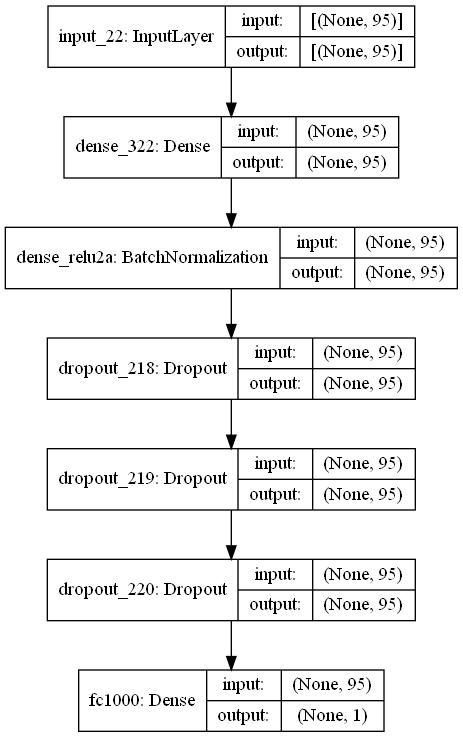

In [61]:

def keras_model_for_sklearn(optimizer='adam',#'adagrad',
                    loss = 'binary_crossentropy', 
                    kernel_initializer='glorot_uniform', 
                    dropout=0.2, layers_n  = 95,
                    n_activator = 'relu',
                    neurons = 213 ,
                    n_out = 1,
                    f_activator = 'relu',
                    batch_norm = True,
                    metrics = ['accuracy', 'MeanSquaredError', 'AUC', "RootMeanSquaredError"]
                  ):
        
    
    input =tensorflow.keras.layers.Input(shape=(layers_n,))
    output1 =tensorflow.keras.layers.Dense(layers_n, input_shape=(layers_n,), activation=n_activator)(input)
    if batch_norm:
        output1 =tensorflow.keras.layers.BatchNormalization(axis=1, name='dense_relu' + '2a')(output1)
    output1 =tensorflow.keras.layers.Dropout(dropout)(output1)
    dense_name_base = "dense"
    bn_name_base = "dense_additionall"
    shortcut1 =tensorflow.keras.layers.Dense(layers_n, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '1')(output1)
    output1 =tensorflow.keras.layers.Dropout(dropout)(output1)

    # if batch_norm:
    #     output1 =tensorflow.keras.layers.BatchNormalization(axis=1, name=bn_name_base + '2a')(output1)
    # shortcut2 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
    #                             name=dense_name_base + '2')(output1)
    
    # output1 =tensorflow.keras.layers.Dropout(dropout)(output1)
    # shortcut1 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
    #                             name=dense_name_base + '22')(output1)
    
    output1 =tensorflow.keras.layers.Dropout(dropout)(output1)
    output =tensorflow.keras.layers.Dense(n_out, activation=f_activator, name='fc1000')(output1)
    
    # Final model
    model =tensorflow.keras.models.Model(inputs=input, outputs=output)
    


    # Plot model information
    plot_= True
    # plot_model(model, to_file=OUTPUT_MODEL_ARCHITECTURE_RESULTS, show_shapes=True, show_layer_names=True)
    if plot_:
        plot_model(model, to_file=OUTPUT_MODEL_ARCHITECTURE_RESULTS, show_shapes=True, show_layer_names=True)
        im = cv2.imread(OUTPUT_MODEL_ARCHITECTURE_RESULTS, 0)
        model.summary()
        display(Image(filename=OUTPUT_MODEL_ARCHITECTURE_RESULTS))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model
# keras_model_for_sklearn()

### Creating Keras model 

In [70]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Dropout,     BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, fbeta_score, make_scorer

from sklearn.metrics import recall_score, f1_score, roc_auc_score, accuracy_score, precision_score, precision_recall_curve, average_precision_score


# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(optimizer='adam', kernel_initializer='normal', dropout=0.2, layers_n = 64, metrics="accuracy", batchn = True):
    model = Sequential()
    model.add(Dense(layers_n,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    if batchn:
        model.add(BatchNormalization())
    model.add(Dense(1,activation='relu',kernel_initializer=kernel_initializer))
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=[metrics])
    return model

In [71]:

    

HYPER_PARAMETER_K_FEATURES = list([20,25,30,35,40,95])
HYPER_PARAMETER_SCORE_FUNC = [chi2, f_classif]
HYPER_PARAMETER_CLASIFIER_OPTIMIZERS = ['rmsprop','adam','adagrad']
HYPER_PARAMETER_EPOCHS = [10,20,40,60]
HYPER_PARAMETER_DROPUT = [0,0.1,0.2,0.3]
HYPER_PARAMETER_LAYERS_N = list(range(20,90,10))
HYPER_PARAMETER_BATCH_NUMBER = list(range(20,160,30))
HYPER_PARAMETER_KERNEL_INITIALIZER = ['glorot_uniform','normal','uniform']
HYPER_PARAMETER_CLASIFIER_METRICS = ['accuracy']

param_grid = {
    "selection__k": HYPER_PARAMETER_K_FEATURES,
    "selection__score_func": HYPER_PARAMETER_SCORE_FUNC,
    'clf__optimizer':HYPER_PARAMETER_CLASIFIER_OPTIMIZERS,
    'clf__epochs':HYPER_PARAMETER_EPOCHS,
    'clf__dropout':HYPER_PARAMETER_DROPUT,
    'clf__layers_n' : HYPER_PARAMETER_LAYERS_N,
    'clf__batchn' : HYPER_PARAMETER_BATCH_NUMBER,
    'clf__kernel_initializer':HYPER_PARAMETER_KERNEL_INITIALIZER,
    'clf__metrics':HYPER_PARAMETER_CLASIFIER_METRICS,
}


param_grid = {
    'clf__optimizer':['adam'],
    'clf__epochs':[10],
    'clf__dropout':[0.2],
    'clf__layers_n' : [64],
    'clf__kernel_initializer':['uniform'],
    'clf__metrics':['accuracy'],
    "selection__k": [30],
    "selection__score_func": [chi2],
}


# Using keras regresor for our custom model
clf = KerasRegressor(build_fn=create_model,verbose=3)

# Definng standart scalers
scaler = StandardScaler()

# Do feature selection with SelectKBest.
feature_selection = SelectKBest(f_classif,  k=64)  

# Oversample data with SMOTE
smote = SMOTE(sampling_strategy="minority", random_state=RANDOM_SEED)
X_train, y_train = training_features,training_targets
X_train, y_train = smote.fit_resample(training_features,training_targets)
# Min max scaler definition 
min_max_scaler =  MinMaxScaler()

# Feature selection 
feature_selection = SelectKBest()

pipeline = Pipeline([
    ('preprocess',scaler),
    ("min_max_scaler", min_max_scaler),
    ("selection", feature_selection),
    ('clf',clf)
])

# Define custom fbeta scorer function that put emphasis on recall
def custom_scorer(y_true, y_pred):
    confidence = 0
    y_pred = (np.where(y_pred > confidence, 1, 0))    
    print(confusion_matrix(y_true, y_pred))
    return fbeta_score(y_true, y_pred, beta=HYPER_PARAMETER_OPTIMIZATION_BETA)

grid = GridSearchCV(pipeline, 
                            cv=5,
                            param_grid=param_grid
                            , verbose = 3 
                            , scoring=make_scorer(custom_scorer)
                            )

grid.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[[  65 2047]
 [   0    0]]
[CV 1/5] END clf__dropout=0.2, clf__epochs=10, clf__kernel_initializer=uniform, clf__layers_n=64, clf__metrics=accuracy, clf__optimizer=adam, selection__k=30, selection__score_func=<function chi2 at 0x000001BDE4872EE0>;, score=0.000 total time=   7.4s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[[ 486 1626]
 [   0    0]]
[CV 2/5] END clf__dropout=0.2, clf__epochs=10, clf__kernel_initializer=uniform, clf__layers_n=64, clf__metrics=accuracy, clf__optimizer=adam, selection__k=30, selection__score_func=<function chi2 at 0x000001BDE4872EE0>;, score=0.000 total time=   7.2s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[[ 162  893]
 [   0 1057]]
[CV 3/5] END clf__dropo

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess', StandardScaler()),
                                       ('min_max_scaler', MinMaxScaler()),
                                       ('selection', SelectKBest()),
                                       ('clf',
                                        <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001BDF1DCDD90>)]),
             param_grid={'clf__dropout': [0.2], 'clf__epochs': [10],
                         'clf__kernel_initializer': ['uniform'],
                         'clf__layers_n': [64], 'clf__metrics': ['accuracy'],
                         'clf__optimizer': ['adam'], 'selection__k': [30],
                         'selection__score_func': [<function chi2 at 0x000001BDE4872EE0>]},
             scoring=make_scorer(custom_scorer), verbose=3)

In [72]:
print("Best model: Acc. Score = %f, with parameters %s" % (grid.best_score_, grid.best_params_))

Best model: Acc. Score = 0.571091, with parameters {'clf__dropout': 0.2, 'clf__epochs': 10, 'clf__kernel_initializer': 'uniform', 'clf__layers_n': 64, 'clf__metrics': 'accuracy', 'clf__optimizer': 'adam', 'selection__k': 30, 'selection__score_func': <function chi2 at 0x000001BDE4872EE0>}


## For single class

In [77]:
def output_parameters(confidence, grid, training_features, training_targets,evaluation_features, evaluation_targets, max_acc,best_conf, log = False ):
    from sklearn.metrics import confusion_matrix, classification_report, roc_curve, recall_score, make_scorer

    # Use all training data to calculate confusion matrix for training data
    training_estimates_ = grid.predict(training_features)
    training_estimates = np.where(training_estimates_ > confidence, 1, 0)

    training_accuracy = balanced_accuracy_score(training_targets, training_estimates)
    training_confusion_matrix = confusion_matrix(training_targets, training_estimates)

    # Use model to estimate manually labeled evaluation Tweets
    evaluation_estimates_ = grid.predict(evaluation_features)

    evaluation_estimates = np.where(evaluation_estimates_ > confidence, 1, 0)

    evaluation_accuracy = balanced_accuracy_score(evaluation_targets, evaluation_estimates)
    evaluation_confusion_matrix = confusion_matrix(evaluation_targets, evaluation_estimates)
    
    # evaluation_confusion_matrix = confusion_matrix_to_string(evaluation_confusion_matrix)
    if max_acc <= evaluation_accuracy:
        max_acc = evaluation_accuracy
        best_conf = confidence

    print(f"Confidence {confidence}")
    if log:
        print(training_estimates_)
        print("\n\n\n\n\n\n_________________________________________________")
        print(training_estimates)
        print(training_confusion_matrix)
        print(evaluation_estimates_[:5])
        print(evaluation_estimates[:5])
        print(evaluation_confusion_matrix)

    print(f"Balanced training. acc: {training_accuracy}")

    print(f"Balanced eval. acc: {evaluation_accuracy}")

    # summarize results

    if log:
        print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
        means = grid.cv_results_['mean_test_score']
        stds = grid.cv_results_['std_test_score']
        params = grid.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))

        print("Training evaluation")

        y_pred_train_ = grid.predict(training_features)
        print(y_pred_train_)
        y_pred_train = np.where(y_pred_train_ > confidence, 1, 0)
        print(classification_report(training_targets, y_pred_train))
        train_conf_matrix = confusion_matrix(training_targets, y_pred_train)

        print("Validation/evaluation")
        y_pred_test_ = grid.predict(evaluation_features) # prediction on our test set

        print(y_pred_test_)
        y_pred_test = np.where(y_pred_test_ > confidence, 1, 0)

        print(classification_report(evaluation_targets, y_pred_test))
        test_conf_matrix = confusion_matrix(evaluation_targets, y_pred_test)
        print(test_conf_matrix)
    return max_acc, best_conf

confidences =  numpy.arange(0, 1,0.02)
max_acc = 0
best_conf = 0
log = False

for confidence in confidences:
    max_acc,best_conf = output_parameters(confidence, grid, training_features, training_targets,evaluation_features, evaluation_targets, max_acc,best_conf, log = False )

print(f"max_acc {max_acc}, best_conf{best_conf}")

Confidence 0.0
Balanced training. acc: 0.5518090547452169
Balanced eval. acc: 0.5496212121212121
Confidence 0.02
Balanced training. acc: 0.5564500852434173
Balanced eval. acc: 0.5537878787878788
Confidence 0.04
Balanced training. acc: 0.5615646902822504
Balanced eval. acc: 0.5606060606060606
Confidence 0.06
Balanced training. acc: 0.5672475847698428
Balanced eval. acc: 0.5662878787878788
Confidence 0.08
Balanced training. acc: 0.572741049441182
Balanced eval. acc: 0.571590909090909
Confidence 0.1
Balanced training. acc: 0.578708088653154
Balanced eval. acc: 0.578030303030303
Confidence 0.12
Balanced training. acc: 0.585906421670771
Balanced eval. acc: 0.5837121212121212
Confidence 0.14
Balanced training. acc: 0.591873460882743
Balanced eval. acc: 0.5905303030303031
Confidence 0.16
Balanced training. acc: 0.5988823640841068
Balanced eval. acc: 0.6007575757575757
Confidence 0.18
Balanced training. acc: 0.6071225610911157
Balanced eval. acc: 0.6068181818181818
Confidence 0.2
Balanced trai

In [80]:
confidence = best_conf
max_acc,best_conf = output_parameters(best_conf, grid, training_features, training_targets,evaluation_features, evaluation_targets, max_acc,best_conf, log = True )


Confidence 0.68
[0.8568503  0.62766576 0.5119387  ... 0.85932463 0.85833764 0.8032442 ]






_________________________________________________
[1 0 0 ... 1 1 1]
[[4304  975]
 [  18  158]]
[0.063197   0.72003967 0.59934664 0.32935068 0.4652993 ]
[0 1 0 0 0]
[[1045  275]
 [   7   37]]
Balanced training. acc: 0.8565166009402607
Balanced eval. acc: 0.8162878787878788
Best: 0.571091 using {'clf__dropout': 0.2, 'clf__epochs': 10, 'clf__kernel_initializer': 'uniform', 'clf__layers_n': 64, 'clf__metrics': 'accuracy', 'clf__optimizer': 'adam', 'selection__k': 30, 'selection__score_func': <function chi2 at 0x000001BDE4872EE0>}
0.571091 (0.469271) with: {'clf__dropout': 0.2, 'clf__epochs': 10, 'clf__kernel_initializer': 'uniform', 'clf__layers_n': 64, 'clf__metrics': 'accuracy', 'clf__optimizer': 'adam', 'selection__k': 30, 'selection__score_func': <function chi2 at 0x000001BDE4872EE0>}
Training evaluation
[0.8568503  0.62766576 0.5119387  ... 0.85932463 0.85833764 0.8032442 ]
              prec